## Imports

In [19]:
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from itertools import product
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# For proper display of all columns
pd.options.display.max_columns = None

## We are working with the "clean" data, wich means we use separate dataframes, but after DQC and ETL steps

In [20]:
items = pd.read_csv(
    './competitive-data-science-predict-future-sales/transformed_data/items.csv')
shops = pd.read_csv(
    "./competitive-data-science-predict-future-sales/transformed_data/shops.csv")
cats = pd.read_csv(
    "./competitive-data-science-predict-future-sales/transformed_data/item_categories.csv")
train = pd.read_csv(
    "./competitive-data-science-predict-future-sales/transformed_data/sales_train.csv")

# Creating a data dictionary for later usage
train_data_dict = {"items": items,
                   "shops": shops,
                   "cats": cats,
                   "train": train}

# Setting index to ID to avoid droping it later
test = pd.read_csv(
    "./competitive-data-science-predict-future-sales/transformed_data/test.csv").set_index("ID")

In [21]:
train = train.query("item_price>0 and item_price<40000 and item_cnt_day<500")
# Splitting shop name to get the city name
shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
shops["city"] = shops["city"].replace("!", "", regex=True)

# Label encoding so that it is more readable
shops["city_code"] = LabelEncoder().fit_transform(shops["city"])
shops.drop(["city"], axis=1, inplace=True)
shops.drop(["shop_name"], axis=1, inplace=True)

# Splitting category name to get the item type.
cats["item_cat_split"] = cats["item_category_name"].str.split("-")
cats["type"] = cats["item_cat_split"].map(lambda x: x[0].strip())
cats["type_code"] = LabelEncoder().fit_transform(cats["type"])

# Splitting category name to get the item type.
cats["subcat"] = cats["item_cat_split"].map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip()
)
cats["subcat_code"] = LabelEncoder().fit_transform(cats["subcat"])
cats = cats[["item_category_id", "type_code", "subcat_code"]]

# Dropping item names from items df as we discussed
# Create the date the product was first sold as a feature
items["first_sale_date"] = train.groupby("item_id").agg({"date_block_num": "min"})[
    "date_block_num"
]

items.drop(["item_name"], axis=1, inplace=True)

In [22]:
train = (
    train.merge(items, on="item_id", how="left")
    .merge(shops, on="shop_id", how="left")
    .merge(cats, on="item_category_id", how="left")
)

test = (
    test.merge(items, on="item_id", how="left")
    .merge(shops, on="shop_id", how="left")
    .merge(cats, on="item_category_id", how="left")
)

## Grouping on month level as our we need to predict next month total sales

In [23]:
train_monthly = train.groupby(
    [
        "date_block_num",
        "shop_id",
        "item_category_id",
        "item_id",
        "city_code",
        "type_code",
        "subcat_code",
    ],
    as_index=False,
)
train_monthly = train_monthly.agg(
    {"item_price": "mean", "item_cnt_day": ["sum", "mean", "count"]}
).reset_index(drop="True")
train_monthly.columns = [
    "date_block_num",
    "shop_id",
    "item_category_id",
    "item_id",
    "city_code",
    "type_code",
    "subcat_code",
    "item_price",
    "item_cnt",
    "mean_item_cnt",
    "transactions",
]

In [24]:
test["item_cnt"] = 0
test["date_block_num"] = 34
cols = [
    "shop_id",
    "item_id",
    "date_block_num",
    "item_category_id",
    "city_code",
    "type_code",
    "subcat_code",
    "first_sale_date",
]
train_monthly = pd.concat(
    [train_monthly, test], ignore_index=True, sort=False, keys=cols
)

In [25]:
train_monthly["year"] = train_monthly["date_block_num"].apply(
    lambda x: ((x // 12) + 2013)
)
train_monthly["month"] = train_monthly["date_block_num"].apply(lambda x: (x % 12))

## creating the revenue feature

In [26]:
train_monthly["revenue"] = train_monthly["item_price"] * train_monthly["item_cnt"]

## some statistical sugar

In [27]:
# Adding min and max price of the item
item_price = (
    train_monthly.sort_values("date_block_num")
    .groupby(["item_id"], as_index=False)
    .agg({"item_price": [np.min, np.max]})
)
item_price.columns = ["item_id", "hist_min_item_price", "hist_max_item_price"]
train_monthly = pd.merge(train_monthly, item_price, on="item_id", how="left")

# Adding average price difference w.r.t the current month with min and max historic price
train_monthly["price_increase"] = (
    train_monthly["item_price"] - train_monthly["hist_min_item_price"]
)
train_monthly["price_decrease"] = (
    train_monthly["hist_max_item_price"] - train_monthly["item_price"]
)

# Adding first month of selling of a product
train_monthly["first_selling_date_block"] = train_monthly.groupby("item_id")[
    "date_block_num"
].min()

# Adding a boolean if a product is a newly launched product or not
train_monthly["is_new_product"] = (
    train_monthly["first_selling_date_block"] == train_monthly["date_block_num"]
)

## Adding rolling window features

In [28]:
# Rolling window features
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

func_list = [f_min, f_max, f_mean, f_std]
func_name = ["min", "max", "mean", "std"]

for i in range(len(func_list)):
    train_monthly[("item_cnt_%s" % func_name[i])] = (
        train_monthly.sort_values("date_block_num")
        .groupby(["shop_id", "item_category_id", "item_id"])["item_cnt"]
        .apply(func_list[i])
    )

# Fill the empty std features with 0
train_monthly["item_cnt_std"].fillna(0, inplace=True)

## this function will help us to create lag features

In [29]:
# Creating lag_features function to create the lags which helps model to predict the future month sales.

def lag_features(df, lags, col_list):
    for col_name in col_list:
        tmp = df[["date_block_num", "shop_id", "item_id", col_name]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = [
                "date_block_num",
                "shop_id",
                "item_id",
                col_name + "_lag_" + str(i),
            ]
            shifted["date_block_num"] += i
            df = pd.merge(
                df, shifted, on=["date_block_num", "shop_id", "item_id"], how="left"
            )
    return df

## creating lag features

In [30]:
# 1.=====Creating monthly, bi-monthly, quarterly, half yearly of target feature===
train_monthly = lag_features(
    train_monthly, [1, 2, 3, 6], ["item_cnt", "mean_item_cnt", "transactions"]
)

# 2.====Creating recent lag features for price feature===
train_monthly = lag_features(train_monthly, [1, 2, 3], ["item_price"])

# 3.====Creating lag feature for category sales====
grp = train_monthly.groupby(["date_block_num", "item_category_id"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_cat_avg_item_cnt"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "item_category_id"], how="left"
)
train_monthly["date_cat_avg_item_cnt"] = train_monthly["date_cat_avg_item_cnt"].astype(
    np.float16
)

# 4.=====Creating lag features for shop level=====
grp = train_monthly.groupby(["date_block_num", "shop_id"]).agg({"item_cnt": ["mean"]})
grp.columns = ["date_shop_cnt"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "shop_id"], how="left"
)
train_monthly["date_shop_cnt"] = train_monthly["date_shop_cnt"].astype(np.float16)

# 5.====Creating lag features for shop and item category level====
grp = train_monthly.groupby(["date_block_num", "shop_id", "item_category_id"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_shop_cat_avg_item_cnt"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "shop_id", "item_category_id"], how="left"
)
train_monthly["date_shop_cat_avg_item_cnt"] = train_monthly[
    "date_shop_cat_avg_item_cnt"
].astype(np.float16)

# 6.=====Creating lag features for shop and item type=====
grp = train_monthly.groupby(["date_block_num", "shop_id", "type_code"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_shop_type_avg_item_cnt"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "shop_id", "type_code"], how="left"
)
train_monthly["date_shop_type_avg_item_cnt"] = train_monthly[
    "date_shop_type_avg_item_cnt"
].astype(np.float16)

# 7.====Creating lag features for shop and item subcateory type====
grp = train_monthly.groupby(["date_block_num", "shop_id", "subcat_code"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_shop_subcat_avg_item_cnt"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "shop_id", "subcat_code"], how="left"
)
train_monthly["date_shop_subcat_avg_item_cnt"] = train_monthly[
    "date_shop_subcat_avg_item_cnt"
].astype(np.float16)

# 8.====Creating lag features at city level sales====
grp = train_monthly.groupby(["date_block_num", "city_code"]).agg({"item_cnt": ["mean"]})
grp.columns = ["date_city_avg_item_cnt"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "city_code"], how="left"
)
train_monthly["date_city_avg_item_cnt"] = train_monthly[
    "date_city_avg_item_cnt"
].astype(np.float16)

# 9.====Creating lag features at city and item code level====
grp = train_monthly.groupby(["date_block_num", "item_id", "city_code"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_item_city_avg_item_cnt"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "item_id", "city_code"], how="left"
)
train_monthly["date_item_city_avg_item_cnt"] = train_monthly[
    "date_item_city_avg_item_cnt"
].astype(np.float16)

# 10.====Creating lag featuures at item type level====
grp = train_monthly.groupby(["date_block_num", "type_code"]).agg({"item_cnt": ["mean"]})
grp.columns = ["date_type_avg_item_cnt"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "type_code"], how="left"
)
train_monthly["date_type_avg_item_cnt"] = train_monthly[
    "date_type_avg_item_cnt"
].astype(np.float16)

# 11.=====Creating lag features at item sub category level====
grp = train_monthly.groupby(["date_block_num", "subcat_code"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_subtype_avg_item_cnt"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "subcat_code"], how="left"
)
train_monthly["date_subtype_avg_item_cnt"] = train_monthly[
    "date_subtype_avg_item_cnt"
].astype(np.float16)

# Applying lag function
lag_on_list = [
    "date_cat_avg_item_cnt",
    "date_shop_cnt",
    "date_shop_cat_avg_item_cnt",
    "date_shop_type_avg_item_cnt",
    "date_shop_subcat_avg_item_cnt",
    "date_city_avg_item_cnt",
    "date_item_city_avg_item_cnt",
    "date_type_avg_item_cnt",
    "date_subtype_avg_item_cnt",
    "revenue",
]  # Added revenue lags as well

train_monthly = lag_features(train_monthly, [1, 2, 3], lag_on_list)
train_monthly.drop(lag_on_list, axis=1, inplace=True)

In [31]:
# Creating last 3 month average of sales
train_monthly["qmean"] = train_monthly[
    ["item_cnt_lag_1", "item_cnt_lag_2", "item_cnt_lag_3"]
].mean(skipna=True, axis=1)

train_monthly["qmean_rev"] = train_monthly[
    ["revenue_lag_1", "revenue_lag_2", "revenue_lag_3"]
].mean(skipna=True, axis=1)

In [32]:
# Getting some lag ratios to get some kind of trend
train_monthly["item_cat_lag1_ratio"] = (
    train_monthly["item_cnt_lag_1"] / train_monthly["item_cnt_lag_2"]
)
train_monthly["item_cat_lag1_ratio"] = (
    train_monthly["item_cat_lag1_ratio"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
)

train_monthly["item_cat_lag2_ratio"] = (
    train_monthly["item_cnt_lag_2"] / train_monthly["item_cnt_lag_3"]
)
train_monthly["item_cat_lag2_ratio"] = (
    train_monthly["item_cat_lag2_ratio"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
)

# Adding revenue ratio to get additional trend features
train_monthly["rev_lag1_ratio"] = (
    train_monthly["revenue_lag_1"] / train_monthly["revenue_lag_2"]
)
train_monthly["rev_lag2_ratio"] = (
    train_monthly["revenue_lag_2"] / train_monthly["revenue_lag_3"]
)

In [33]:
# Additional Trend features
grp = train.groupby(["item_id"]).agg({"item_price": ["mean"]})
grp.columns = ["avg_item_price"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(train_monthly, grp, on=["item_id"], how="left")
train_monthly["avg_item_price"] = train_monthly["avg_item_price"].astype(np.float16)

grp = train.groupby(["date_block_num", "item_id"]).agg({"item_price": ["mean"]})
grp.columns = ["date_avg_item_price"]
grp.reset_index(inplace=True)

train_monthly = pd.merge(
    train_monthly, grp, on=["date_block_num", "item_id"], how="left"
)
train_monthly["date_avg_item_price"] = train_monthly["date_avg_item_price"].astype(
    np.float16
)

# Taking 6 months of price lags to get the delta of price for trend variable
lags = [1, 2, 3, 4, 5, 6]
train_monthly = lag_features(train_monthly, lags, ["date_avg_item_price"])

# Calculating the deviation from average price to get the delta at different lag
for i in lags:
    train_monthly["delta_price_lag_" + str(i)] = (
        train_monthly["date_avg_item_price_lag_" + str(i)]
        - train_monthly["avg_item_price"]
    ) / train_monthly["avg_item_price"]


# Logic to get the closest non null value to calculate the delta value
def select_trend(row):
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

train_monthly["price_trend"] = train_monthly.apply(select_trend, axis=1)
train_monthly["price_trend"] = train_monthly["price_trend"].astype(np.float16)
train_monthly["price_trend"].fillna(0, inplace=True)

drop_cols = ["avg_item_price", "date_avg_item_price"]
for i in lags:
    drop_cols += ["date_avg_item_price_lag_" + str(i)]
    drop_cols += ["delta_price_lag_" + str(i)]

train_monthly.drop(drop_cols, axis=1, inplace=True)

# replaceing inf and -inf with 0
train_monthly = train_monthly.replace([np.inf, -np.inf], np.nan).fillna(0)

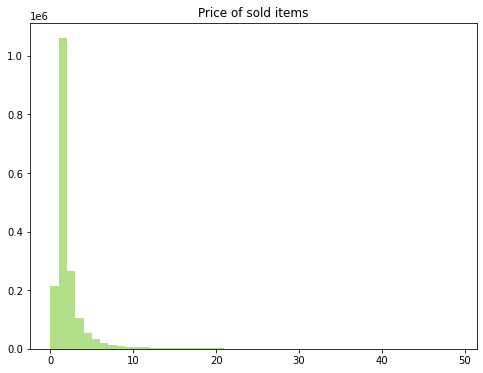

In [34]:
plt.figure(figsize=(8,6))
colors = sns.color_palette('Paired')[2]
plt.hist(train_monthly.item_cnt, color = colors, bins = list(range(0,50, 1)))
plt.title('Price of sold items')
plt.show()

## As we see, it can be better if we clip this range

In [35]:
train_monthly["item_cnt"] = train_monthly["item_cnt"].clip(0, 20)

In [36]:
train_monthly.sample(10)

,date_block_num,shop_id,item_category_id,item_id,city_code,type_code,subcat_code,item_price,item_cnt,mean_item_cnt,transactions,first_sale_date,year,month,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,first_selling_date_block,is_new_product,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_lag_1,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_6,mean_item_cnt_lag_1,mean_item_cnt_lag_2,mean_item_cnt_lag_3,mean_item_cnt_lag_6,transactions_lag_1,transactions_lag_2,transactions_lag_3,transactions_lag_6,item_price_lag_1,item_price_lag_2,item_price_lag_3,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_shop_cnt_lag_1,date_shop_cnt_lag_2,date_shop_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_subcat_avg_item_cnt_lag_1,date_shop_subcat_avg_item_cnt_lag_2,date_shop_subcat_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_3,revenue_lag_1,revenue_lag_2,revenue_lag_3,qmean,qmean_rev,item_cat_lag1_ratio,item_cat_lag2_ratio,rev_lag1_ratio,rev_lag2_ratio,price_trend
536447,9,25,55,17503,13,13,2,249.0,1.0,1.0,1.0,0.0,2013,9,148.0,249.0,101.0,0.0,0.0,False,1.0,4.0,2.000000,1.732051,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.000000
1457827,29,24,75,3007,13,15,30,1990.0,2.0,1.0,2.0,0.0,2015,5,1128.0,2090.0,862.0,100.0,0.0,False,1.0,2.0,1.666667,0.577350,1.0,2.0,5.0,2.0,1.0,1.0,1.250000,1.0,1.0,2.0,4.0,2.0,1990.0,1990.0,1990.0,2.328125,2.419922,2.630859,2.015625,2.148438,1.998047,2.949219,3.500000,4.035156,3.041016,3.267578,3.878906,2.949219,3.500000,4.035156,2.494141,2.669922,2.316406,1.333008,2.166016,2.599609,2.257812,2.486328,2.507812,2.328125,2.419922,2.630859,1990.0,3980.0,9950.0,2.666667,5306.666667,0.5,0.40,0.5,0.40,0.031982
542461,9,29,55,2458,13,13,2,299.0,2.0,1.0,2.0,0.0,2013,9,158.0,299.0,141.0,0.0,0.0,False,1.0,2.0,1.333333,0.577350,1.0,1.0,0.0,0.0,1.0,1.0,0.000000,0.0,1.0,1.0,0.0,0.0,299.0,299.0,0.0,1.381836,1.447266,0.000000,2.775391,1.999023,0.000000,1.378906,1.448242,0.000000,1.378906,1.446289,0.000000,1.378906,1.448242,0.000000,2.955078,2.476562,0.000000,2.750000,3.699219,0.000000,1.358398,1.420898,0.000000,1.381836,1.447266,0.000000,299.0,299.0,0.0,1.000000,299.000000,1.0,0.00,1.0,0.00,0.010986
482448,8,25,23,4781,13,5,16,799.0,1.0,1.0,1.0,0.0,2013,8,249.0,1199.0,550.0,400.0,0.0,False,1.0,1.0,1.000000,0.000000,1.0,1.0,2.0,6.0,1.0,1.0,1.000000,1.0,1.0,1.0,2.0,6.0,799.0,799.0,799.0,2.363281,1.936523,2.246094,2.585938,2.433594,2.693359,2.701172,2.337891,3.027344,3.148438,2.652344,3.953125,2.681641,2.330078,2.953125,2.476562,2.310547,2.515625,1.750000,1.571289,2.333984,2.304688,2.066406,2.615234,2.335938,1.965820,2.191406,799.0,799.0,1598.0,1.333333,1065.333333,1.0,0.50,1.0,0.50,0.186279
879055,15,57,37,12841,29,11,1,399.0,1.0,1.0,1.0,0.0,2014,3,265.0,399.0,134.0,0.0,0.0,False,1.0,1.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0

## Saving

In [37]:
train_monthly.to_pickle("train_monthly.pkl")